In [55]:
import os

import timm
import torch
import torch.nn as nn

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

### timm에서 지원하는 모델, (with pretrained)

In [8]:
print('total_:',len(timm.list_models('*')))
print('pretrained_:',len(timm.list_models(pretrained=True)))

print(timm.list_models('resnet*', pretrained=True)[:5])

total_: 964
pretrained_: 770
['resnet10t', 'resnet14t', 'resnet18', 'resnet18d', 'resnet26']


### 모델 생성 (create_model)

In [24]:
model = timm.create_model('resnet50', pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

### model summary (num_classes, input_size, polling size...)

In [10]:
print(model.default_cfg)

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet50d_ra2-464e36ba.pth', 'num_classes': 1000, 'input_size': (3, 224, 224), 'pool_size': (7, 7), 'crop_pct': 0.875, 'interpolation': 'bicubic', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'first_conv': 'conv1.0', 'classifier': 'fc', 'architecture': 'resnet50d'}


# Tuning models

### 1. 다양한 크기의 input channel size 호환

In [14]:
m = model
x = torch.randn(1, 3, 224, 224)
print(m(x).shape)

# 지원되지 않는 크기의 입력 채널 : error!!
y = torch.randn(1, 1, 224, 224)
print(m(y).shape)

torch.Size([1, 1000])


RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[1, 1, 224, 224] to have 3 channels, but got 1 channels instead

In [25]:
#in_chans = 1 --> 3 channels weight를 단일 채널로 합산하여 feeding

m = timm.create_model('resnet50', pretrained=True, in_chans=1)
y = torch.randn(1, 1, 224 ,224)
print(m(y).shape)

torch.Size([1, 1000])


### 2. num_classes

In [19]:
#기존 모델의 classifier head (num_classes = 1000)
print(m.fc)
#혹은
print(m.get_classifier())

Linear(in_features=2048, out_features=1000, bias=True)
Linear(in_features=2048, out_features=1000, bias=True)


In [20]:
#num_classes=10 으로 미세조정
m = timm.create_model('resnet50', pretrained=True, num_classes=10)
print(m.get_classifier())

Linear(in_features=2048, out_features=10, bias=True)


#### num_classes = 0 으로 하는 경우 : classifier 이전 layer에 대한 결과 출력이 가능

In [21]:
m = timm.create_model('resnet50', pretrained=True, num_classes=0)
print(m.get_classifier())

Identity()


### 3. drop_rate (드롭패스)

In [23]:
m = timm.create_model('resnet50', pretrained=True, drop_rate=0.2)

### 4. pooling layer

In [22]:
m.global_pool

SelectAdaptivePool2d (pool_type=avg, flatten=Flatten(start_dim=1, end_dim=-1))

#### pooling layer 변경

In [27]:
m = timm.create_model('resnet50', pretrained=True, global_pool='max')
m.global_pool

SelectAdaptivePool2d (pool_type=max, flatten=Flatten(start_dim=1, end_dim=-1))

#### 혹은 reset_classifier 를 사용하여 변경 가능

In [28]:
m = timm.create_model('resnet50', pretrained=True)
print(m.global_pool)
print(m.get_classifier())
m.reset_classifier(10, 'max')
print(m.global_pool)
print(m.get_classifier())

SelectAdaptivePool2d (pool_type=avg, flatten=Flatten(start_dim=1, end_dim=-1))
Linear(in_features=2048, out_features=1000, bias=True)
SelectAdaptivePool2d (pool_type=max, flatten=Flatten(start_dim=1, end_dim=-1))
Linear(in_features=2048, out_features=10, bias=True)


### model.fc에 직접 접근해서 새로운 classifier 선언 가능

In [30]:
m = timm.create_model('resnet50', pretrained=True)

features_num = model.get_classifier().in_features
print(features_num)

2048


In [33]:
m.fc = nn.Sequential(
    nn.Linear(in_features=features_num, out_features = 100),
    nn.ReLU(),
    nn.Linear(in_features = 100, out_features = 10, bias = False))

m.eval()
print(m(torch.randn(1, 3, 224, 224)).shape)

torch.Size([1, 10])


## 특징 추출 및 시각화

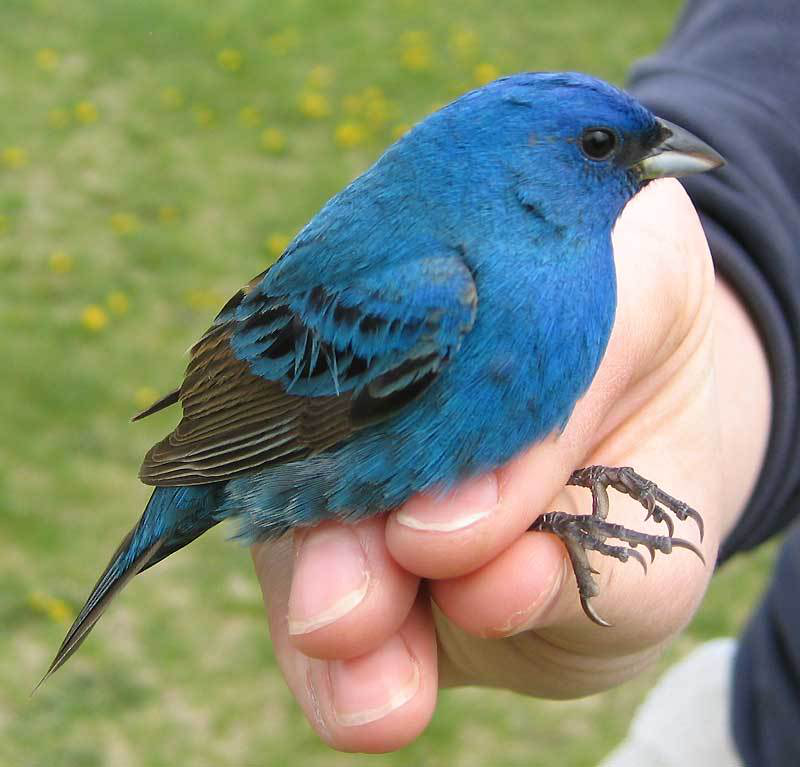

In [2]:
image = Image.open('n01537544_224.JPEG')
image

In [42]:
image = torch.as_tensor(np.array(image, dtype=np.float32)).transpose(2, 0)[None]
print(image.shape)

torch.Size([1, 3, 800, 767])


### 일반적으로 model 은 forward_feature 와 forward_head(fc layer) 로 구성

In [51]:
m = timm.create_model('resnet50', pretrained=True)

feature_output = m.forward_features(image)

### forward_features 의 결과만 접근할 수도 있음

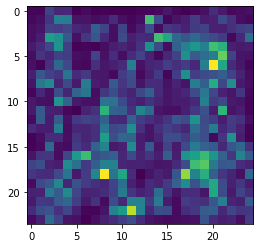

In [46]:
plt.imshow(feature_output[0].transpose(0, 2).sum(-1).detach().numpy())
plt.show()

### 혹은 layer 1, layer 2, layer 3, layer 4에만 접근할 수도 있음

In [53]:
m = timm.create_model('resnet50', pretrained=True, features_only=True)
print(m.feature_info.module_name())
print(m.feature_info.channels())
print(m.feature_info.reduction())

['act1', 'layer1', 'layer2', 'layer3', 'layer4']
[64, 256, 512, 1024, 2048]
[2, 4, 8, 16, 32]


In [55]:
output = m(image)

for feat in output:
    print(feat.shape)

torch.Size([1, 64, 400, 384])
torch.Size([1, 256, 200, 192])
torch.Size([1, 512, 100, 96])
torch.Size([1, 1024, 50, 48])
torch.Size([1, 2048, 25, 24])


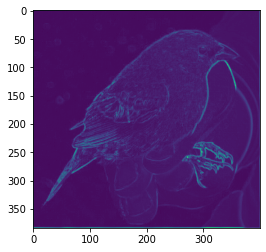

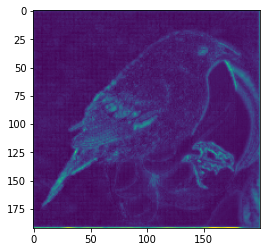

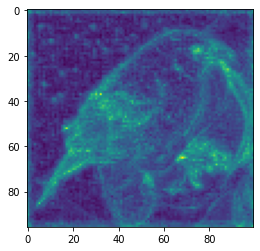

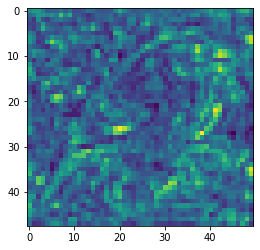

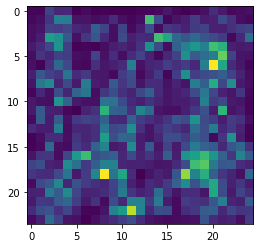

In [56]:
for feat in output:
    plt.imshow(feat[0].transpose(0, 2).sum(-1).detach().numpy())
    plt.show()

### 모델에 조금 더 세부적으로 접근하는 방법

In [57]:
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor

m = timm.create_model('resnet50', pretrained=True, exportable=True)

nodes, _ = get_graph_node_names(m)

In [61]:
print(nodes[:5])

['x', 'conv1', 'bn1', 'act1', 'maxpool']


In [68]:
#resnet의 layer 1의 첫 번째 bottleneck 의 conv1 에 접근

features = {'layer1.0.conv1' : 'output'}
feature_extractor = create_feature_extractor(model, return_nodes=features)
print(feature_extractor)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Module(
    (0): Module(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
)



def forward(self, x):
    conv1 = self.conv1(x);  x = None
    bn1 = self.bn1(conv1);  conv1 = None
    act1 = self.act1(bn1);  bn1 = None
    maxpool = self.maxpool(act1);  act1 = None
    layer1_0_conv1 = getattr(self.layer1, "0").conv1(maxpool);  maxpool = None
    return {'output': layer1_0_conv1}
    


#### layer 1의 첫 번째 bottleneck의 conv1에 대한 결과물 출력

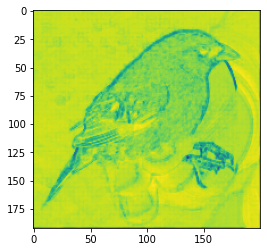

In [69]:
feat = feature_extractor(image)
plt.imshow(feat['output'][0].transpose(0, 2).sum(-1).detach().numpy())





# Data augmentation

## 1. create_transform
#### 기본적 augmentation 기법은 다 제공됨
#### is_training = True 설정 시, 자동으로 가장 기본적인 학습 데이터 증강 파이프라인이 호출됨

In [29]:
from timm.data.transforms_factory import create_transform

print(create_transform(224,))
print('----------  + is_training -----------')
print(create_transform(224, is_training=True))
print('----------  + color jitter, interpolation, hflip, crop 등등 변경 가능 -----------')
print(create_transform(224, is_training=True, interpolation='bicubic'))

Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)
----------  + is_training -----------
Compose(
    RandomResizedCropAndInterpolation(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    RandomHorizontalFlip(p=0.5)
    ColorJitter(brightness=[0.6, 1.4], contrast=[0.6, 1.4], saturation=[0.6, 1.4], hue=None)
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)
----------  + color jitter, interpolation, hflip, crop 등등 변경 가능 -----------
Compose(
    RandomResizedCropAndInterpolation(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bicubic)
    RandomHorizontalFlip(p=0.5)
    ColorJitter(brightness=[0.6, 1.4], contrast=[0.6, 1.4], saturation=[0.6, 1.4], hue=None)
    ToTensor()
    Normalize(mean=tensor([0.48

### Random_resize crop

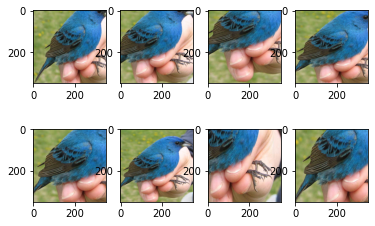

In [23]:
from timm.data.transforms import RandomResizedCropAndInterpolation

aug = RandomResizedCropAndInterpolation(size=350, interpolation='random')


fig, ax = plt.subplots(2, 4)

for idx, img in enumerate([aug(image) for i in range(4)]):
    ax[0, idx].imshow(img)
for idx, img in enumerate([aug(image) for i in range(4)]):
    ax[1, idx].imshow(img)

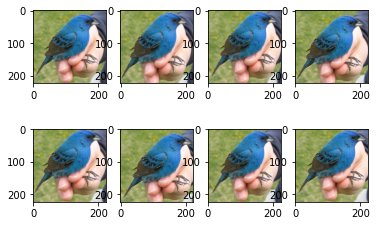

In [24]:
aug = RandomResizedCropAndInterpolation(size=224, scale=(0.8, 1), interpolation='random')


fig, ax = plt.subplots(2, 4)

for idx, img in enumerate([aug(image) for i in range(4)]):
    ax[0, idx].imshow(img)
for idx, img in enumerate([aug(image) for i in range(4)]):
    ax[1, idx].imshow(img)

### Random Erasing

#### - 일반적으로 Cutout과는 같이 쓰지 않음
#### - Cutout보다 이미지의 평균과 표준편차 훼손을 덜 시킴
#### - url : https://timm.fast.ai/RandomErase

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


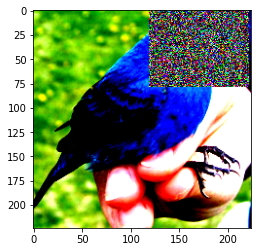

In [34]:
from timm.data.random_erasing import RandomErasing
from torchvision import transforms

x = create_transform(224,)(image)

aug = RandomErasing(probability = 1, mode='pixel')

plt.imshow(aug(x).permute(1, 2, 0))

### RandAugment
#### 어떤 증강기법을 어떤 순서로, 얼만큼의 강도로 적용할 것인가?
#### M : 왜곡 정도   |   N : 왜곡의 수
#### equalization, rotation, solarization, color jittering, posterizing, changing contrast, brightness, sharpness, shearing, translation 등등등
#### ex) rand-m9-n3-mstd0.5
#### m : 강도
#### n : 이미지 별 적용할 증강의 수 (default = 2)
#### mstd : 적용되는 노이즈의 표준편차
#### mmax : 강도의 최대값 (default = 10)
#### w : 연산 선택에 영향을 주는 가중치의 확률 지수
#### inc : (bool : 0 or 1) 크기에 따라서 증강의 강도가 증가할것인가?

## Tips : timm에서 제공되는 auto & rand aug는 cifar에 최적화되어있지 않으므로 맹신해선 안됩니다!
#### auto aug paper 에 cifar용 파라미터가 있다고 합니다. 참고하세요.
#### V0, V0R, Original... : auto aug (왜곡 정도, 수 등이 learnable함)

In [35]:
print(create_transform(224, is_training=True, auto_augment='rand-m9-n3-mstd0.5'))

Compose(
    RandomResizedCropAndInterpolation(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    RandomHorizontalFlip(p=0.5)
    RandAugment(n=3, ops=
	AugmentOp(name=AutoContrast, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Equalize, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Invert, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Rotate, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Posterize, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Solarize, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=SolarizeAdd, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Color, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Contrast, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Brightness, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=Sharpness, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=ShearX, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=ShearY, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=TranslateXRel, p=0.5, m=9, mstd=0.5)
	AugmentOp(name=TranslateYRel, p=0.5, m=9, mstd=0.5))
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


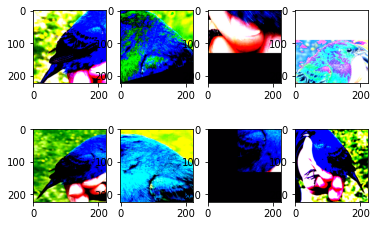

In [39]:
aug = create_transform(224, is_training=True, auto_augment='rand-m9-n3-mstd0.5')

fig, ax = plt.subplots(2, 4)

for idx, img in enumerate([aug(image) for i in range(4)]):
    ax[0, idx].imshow(img.permute(1, 2, 0))
for idx, img in enumerate([aug(image) for i in range(4)]):
    ax[1, idx].imshow(img.permute(1, 2, 0))

### Cutmix & Mixup

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


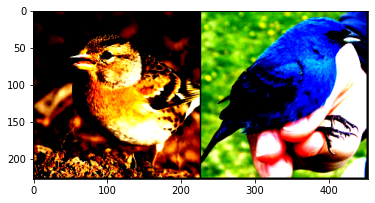

In [48]:
from timm.data import ImageDataset
from torch.utils.data import DataLoader
import torchvision

dataset = ImageDataset('examples/', transform=create_transform(224,))
data = iter(DataLoader(dataset, batch_size = 2))
inputs, classes = next(data)

out = torchvision.utils.make_grid(inputs)
plt.imshow(out.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


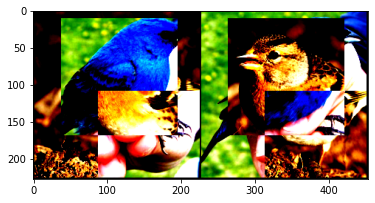

In [60]:
from timm.data.mixup import Mixup

args = {
    'mixup_alpha' : 1.,
    'cutmix_alpha' : 1.,
    'prob' : 1,
    'switch_prob' : 0.9,
    'mode' : 'batch',
    'label_smoothing' : 0.1,
    'num_classes' : 2
}

mixup_fn = Mixup(**args)


output, classes = mixup_fn(inputs.to(torch.device('cuda:0')), classes.to(torch.device('cuda:0')))
out = torchvision.utils.make_grid(output)
plt.imshow(out.permute(1, 2, 0).cpu())

# DataSet
## Create_dataset
### TorchVision, Tensorflow dataset(tfds), or your custom dataset 모두 호출 가능

In [61]:
#torchvision dataset

from timm.data import create_dataset

dataset = create_dataset('torch/cifar100', '.', download=False, split='train')

In [63]:
dataset, type(dataset)

(Dataset CIFAR100
     Number of datapoints: 50000
     Root location: .
     Split: Train,
 torchvision.datasets.cifar.CIFAR100)

# Optimizer
### AdamP, AdamW, sgd, RMSPropTF, LAMB, MADGRAD, AdaHessian ...

In [65]:
import timm.optim
import inspect


[cls_name for cls_name, cls_obj in inspect.getmembers(timm.optim) if inspect.isclass(cls_obj) if cls_name != 'Lookahead']

['AdaBelief',
 'Adafactor',
 'Adahessian',
 'AdamP',
 'AdamW',
 'Lamb',
 'Lars',
 'MADGRAD',
 'Nadam',
 'NvNovoGrad',
 'RAdam',
 'RMSpropTF',
 'SGDP']

#### 간단히 in-place가 가능함. 

In [66]:
m = timm.create_model('resnet50', pretrained=False)
optimizer = timm.optim.create_optimizer_v2(m, opt='sgd', lr=0.01, momentum=0.8)
print(optimizer)
print(type(optimizer))

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    maximize: False
    momentum: 0.8
    nesterov: True
    weight_decay: 0.0
)
<class 'torch.optim.sgd.SGD'>


#### 혹은 직접 생성 가능

In [67]:
optimizer = timm.optim.RMSpropTF(m.parameters(), lr = 0.01)

# Scheduler
### StepLRScheduler : n step마다 lr 감소
### MultiStepLRScheduler : 사용자가 지정한 step마다 lr 변화
### PlateauLRScheduler
### CosineLRScheduler
### TanhLRScheduler
### PolyLRScheduler

In [134]:
from timm import scheduler

epochs = 300
num_epoch_repeat = epochs // 3
num_steps_per_epoch = 10


model = nn.Conv2d(1, 3, kernel_size=3, padding=1, stride=1, bias=False)
optim = timm.optim.create_optimizer_v2(model, opt='sgd', lr= 0.06, momentum=0.9)
scheduler = timm.scheduler.CosineLRScheduler(optim,
                                            t_initial=num_epoch_repeat * num_steps_per_epoch,
#                                            t_initial=10,
                                            lr_min = 1e-5,
                                            cycle_limit = num_epoch_repeat + 1,
                                             t_in_epochs=True,
                                            warmup_lr_init = 0.03,  #초기엔 0.03 으로 10 에폭동안 점진적으로 증가 (lr = 0.06까지)
                                            warmup_t = 10)

#### t_initial : 몇 번에 한 번 반복할것인지. (300으로 하면 300에폭 이후에 똑같은 그래프 생성)
#### lr_min : 최소 lr
#### t_in_epochs : 반복 횟수를 배치 업데이트 횟수가 아닌 epochs 기준으로 할지 여부

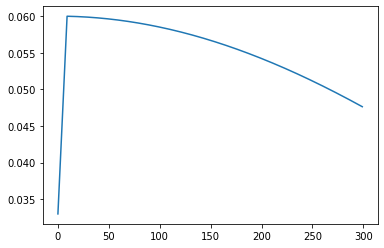

In [133]:
lrs = []

for epoch in range(epochs):
    num_updates = epoch * num_steps_per_epoch
    
    for i in range(num_steps_per_epoch):
        num_updates += 1
        scheduler.step_update(num_updates)
        
    scheduler.step(epoch + 1)
    
    lrs.append(optim.param_groups[0]["lr"])
    
plt.plot(lrs)

In [137]:
from timm import scheduler

epochs = 300
num_epoch_repeat = epochs // 3
num_steps_per_epoch = 10


model = nn.Conv2d(1, 3, kernel_size=3, padding=1, stride=1, bias=False)
optim = timm.optim.create_optimizer_v2(model, opt='sgd', lr= 0.06, momentum=0.9)
scheduler = timm.scheduler.CosineLRScheduler(optim,
                                            t_initial=num_epoch_repeat * num_steps_per_epoch,
#                                            t_initial=10,
                                            lr_min = 1e-5,
                                             noise_range_t = (0, 150), #150 에폭까지 노이즈 추가했음
                                             noise_pct = 0.1, #노이즈 강도
                                            cycle_limit = num_epoch_repeat + 1,
                                             t_in_epochs=True,
                                            warmup_lr_init = 0.03, 
                                            warmup_t = 10)

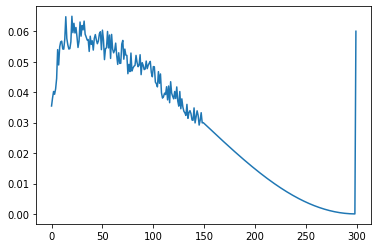

In [138]:
lrs = []

for epoch in range(epochs):
    num_updates = epoch * num_steps_per_epoch
    
    for i in range(num_steps_per_epoch):
        num_updates += 1
        scheduler.step_update(num_updates)
        
    scheduler.step(epoch + 1)
    
    lrs.append(optim.param_groups[0]["lr"])
    
plt.plot(lrs)

# EMA 지수 평균 모델
### 단순히 현재 시점의 모델을 전부 업데이트하는 것이 아니라, 이전 step의 가중치를 참고하여 업데이트 진행

### ema_weight = a * 이전weight + (1-a) * 현재 weight
### decay = 0.99 인 경우, 기존 상태의 99% 유지하고 새 weight의 1%만을 유지

In [ ]:
#예시 코드

model = timm.create_model('resnet50', pretrained=False)
ema_model = ModelEmaV2(model, decay=0.99996)

for epoch in 300:
    for batch in dataloader:
        inputs, targets = batch
        outputs = model(inputs)
        
        loss = loss_fn(outputs, targets)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        #ema here
        model_ema.update(model)
        
    for batch in val_dataloader:
        inp, tar = batch
        out = model(inp)
        val_loss = loss_fn(out, tar)
        
        ema_model_outputs = model_ema.module(inp)
        ema_model_val_loss = loss_fn(ema_model_outputs, targets)

# ema는 지정 위치가 중요함. DDP 적용 시 잘 확인할 것!

# 속도 빠르게!

# Channels_last 
### https://tutorials.pytorch.kr/intermediate/memory_format_tutorial.html
# AMP
### https://pytorch.org/docs/stable/amp.html